In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

c:\Users\IshaG\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 10000               # number of simulations

# Heston dependent parameters
kappa = 2              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.8              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.3            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [3]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    # N : number of time steps
    # M : number of scenarios / simulations
     
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    # reurn - asset prices over time , variance over time
    return S, v

In [7]:
rho_p = 0.9
rho_n = -0.9

S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

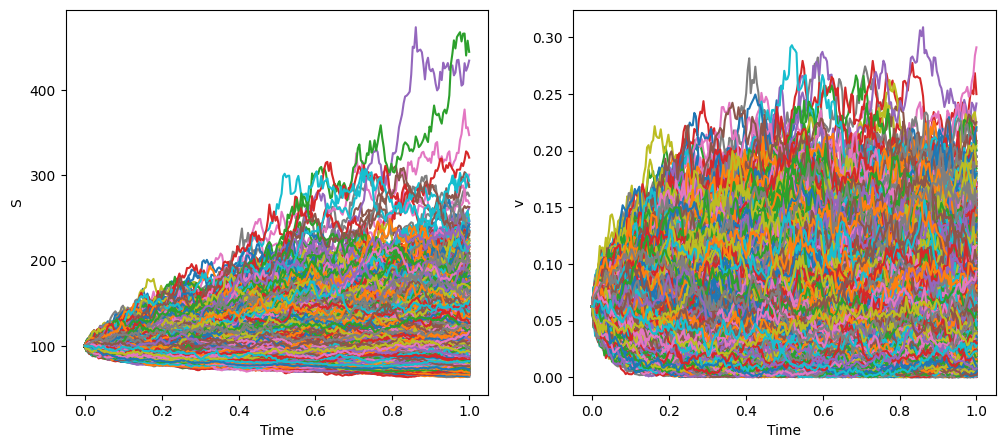

In [9]:
# plot paths
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_xlabel('Time')
ax1.set_ylabel('S')

ax2.plot(time,v_p)
ax2.set_xlabel('Time')
ax2.set_ylabel('v')

plt.show()

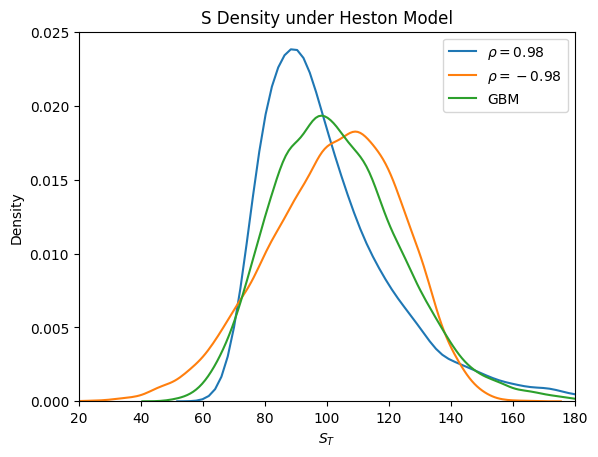

In [10]:
# distribution of the asset prices - different rho
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'S Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

c:\Users\IshaG\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


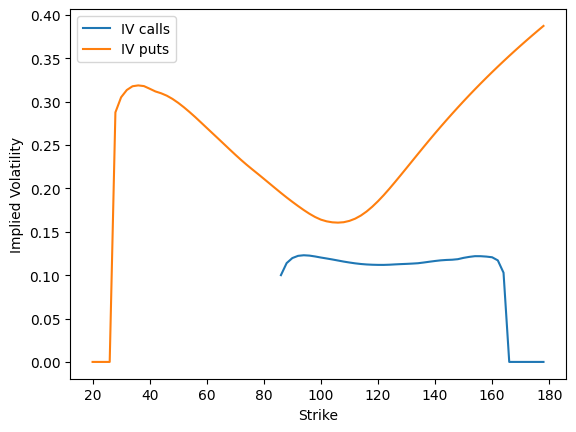

In [28]:
rho = -0.8
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlated Random Variables')

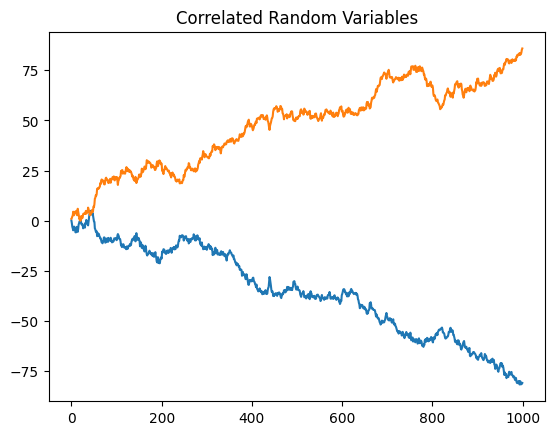

In [11]:
import numpy as np
import matplotlib.pyplot as plt

rho = -0.7
Ndraws = 1000
mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [12]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

In [23]:
kappa =4
theta = 0.02
v_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =50000
steps = 2000
T = 1

prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]       
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T , 
                                np.sqrt(theta)*np.sqrt(T), size=paths))



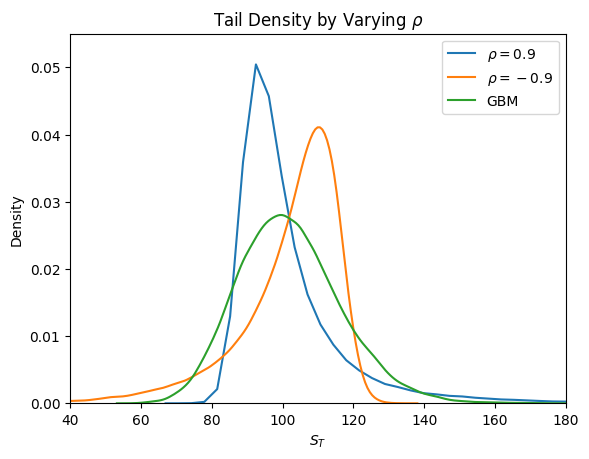

In [24]:
import seaborn as sns

fig, ax = plt.subplots()

ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$ ", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.savefig("S_T density.png", dpi=300)